In [18]:
import numpy as np
import matplotlib.pyplot as plt

C:\Users\linav\AppData\Roaming\Python\Python313\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
C:\Users\linav\AppData\Roaming\Python\Python313\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


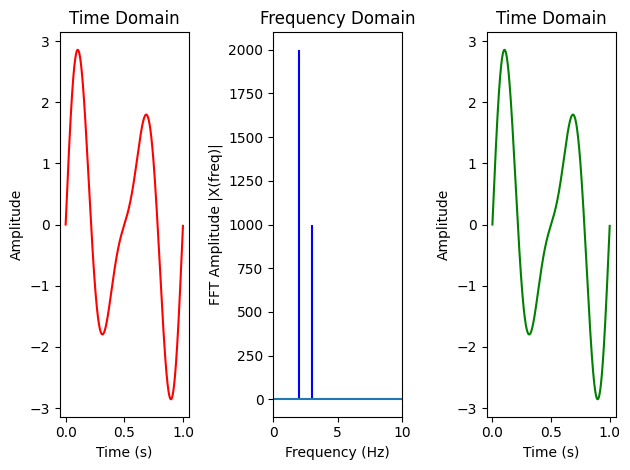

In [19]:
rate = 2000 #sampling rate
interval = 1.0/rate #sampling rate
t = np.arange(0, 1, interval) #time array

data_array_1 = 2*np.sin(2*np.pi*2*t) #sinusoid of frequency 2 Hz 
data_array_2 = np.sin(2*np.pi*3*t) # sinusoid of frequency 3 Hz

signal = data_array_1 + data_array_2 #syum of sinusoids

SIGNAL_transform = np.fft.fft(signal) #Fourier transform of signal
N = len(SIGNAL_transform) #number of data points in frequency domain
n = np.arange(N) #array of N
T = N/rate #sampling period
frequency = n/T #sampling frequency

inverse = np.fft.ifft(SIGNAL_transform)


# Time domain plot
plt.subplot(131)
plt.plot(t, signal, 'r')
plt.title('Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

# Frequency domain plot
plt.subplot(132)
plt.stem(frequency, np.abs(SIGNAL_transform), 'b', markerfmt=" ", basefmt="-")
plt.title('Frequency Domain')
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Amplitude |X(freq)|')
plt.xlim(0, 10)

# Inverse transfrom domain plot
plt.subplot(133)
plt.plot(t, inverse, 'g')
plt.title('Time Domain')
plt.xlabel('Time (s)')
plt.ylabel('Amplitude')

plt.tight_layout()
plt.show()

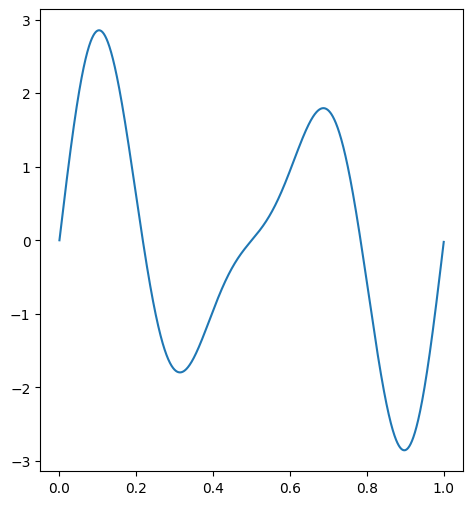

In [20]:
signal = np.fft.ifft(SIGNAL_transform)

plt.figure(figsize = (12, 6))
plt.subplot(121)

plt.plot(t, signal)
plt.show()